# Shelter Animal Outcomes

> [Kaggle](https://www.kaggle.com/competitions/shelter-animal-outcomes/overview/description) this dataset is collected from the data of animal shelters in the USA and our goal is to try to understand what can await the animals that end up in the shelter

## Load Data

In [264]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from matplotlib.colors import ListedColormap
#import re
import seaborn as sns
%matplotlib inline
import pickle

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer

#from collections import Counter
from sklearn.model_selection import train_test_split
#from sklearn.experimental import enable_iterative_imputer
#from sklearn.impute import IterativeImputer
#from sklearn.feature_selection import VarianceThreshold
#from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import Normalizer
#from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_roc_curve

from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, CategoricalNB, BernoulliNB

In [265]:
test = pd.read_csv('test.csv', delimiter=',')
train = pd.read_csv('train.csv', delimiter=',')

In [271]:
train.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [272]:
test.head()

,ID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,1,Summer,2015-10-12 12:15:00,Dog,Intact Female,10 months,Labrador Retriever Mix,Red/White
1,2,Cheyenne,2014-07-26 17:59:00,Dog,Spayed Female,2 years,German Shepherd/Siberian Husky,Black/Tan
2,3,Gus,2016-01-13 12:20:00,Cat,Neutered Male,1 year,Domestic Shorthair Mix,Brown Tabby
3,4,Pongo,2013-12-28 18:12:00,Dog,Intact Male,4 months,Collie Smooth Mix,Tricolor
4,5,Skooter,2015-09-24 17:59:00,Dog,Neutered Male,2 years,Miniature Poodle Mix,White


In [273]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   AnimalID        26729 non-null  object
 1   Name            19038 non-null  object
 2   DateTime        26729 non-null  object
 3   OutcomeType     26729 non-null  object
 4   OutcomeSubtype  13117 non-null  object
 5   AnimalType      26729 non-null  object
 6   SexuponOutcome  26728 non-null  object
 7   AgeuponOutcome  26711 non-null  object
 8   Breed           26729 non-null  object
 9   Color           26729 non-null  object
dtypes: object(10)
memory usage: 2.0+ MB


The first and second columns are not interesting for us, the values in them, if not unique, are very close to those that will only load our model and not give any information. Column "OutcomeSubtype" does not have about half of the values and is not in the test set, so it will be easiest to throw it out as well. And we can work with everything else.

In [274]:
train = train.drop(['AnimalID','Name','OutcomeSubtype'], axis=1)

In [275]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   DateTime        26729 non-null  object
 1   OutcomeType     26729 non-null  object
 2   AnimalType      26729 non-null  object
 3   SexuponOutcome  26728 non-null  object
 4   AgeuponOutcome  26711 non-null  object
 5   Breed           26729 non-null  object
 6   Color           26729 non-null  object
dtypes: object(7)
memory usage: 1.4+ MB


\
It can be seen that one value is lost in column 3 and a little more than ten in column 4. We will throw them out a little later because this is a very small amount of data. All remaining data are objects, except for the 4th column, later we will convert the values into a numerical version. therefore, the 4th column is numerical values, and all others are categorical. There are not enough columns.\
We will fix it.

In [276]:
print(train.apply(lambda x: sum(x.isnull()) / len(train)))

DateTime          0.000000
OutcomeType       0.000000
AnimalType        0.000000
SexuponOutcome    0.000037
AgeuponOutcome    0.000673
Breed             0.000000
Color             0.000000
dtype: float64


In [277]:
for i in train.columns[:-2]:
    print("Column: ", i, "\n")
    print(train[i].unique(),"\n***\n")

Column:  DateTime 

['2014-02-12 18:22:00' '2013-10-13 12:44:00' '2015-01-31 12:28:00' ...
 '2015-05-14 11:56:00' '2015-03-09 13:33:00' '2014-04-27 12:22:00'] 
***

Column:  OutcomeType 

['Return_to_owner' 'Euthanasia' 'Adoption' 'Transfer' 'Died'] 
***

Column:  AnimalType 

['Dog' 'Cat'] 
***

Column:  SexuponOutcome 

['Neutered Male' 'Spayed Female' 'Intact Male' 'Intact Female' 'Unknown'
 nan] 
***

Column:  AgeuponOutcome 

['1 year' '2 years' '3 weeks' '1 month' '5 months' '4 years' '3 months'
 '2 weeks' '2 months' '10 months' '6 months' '5 years' '7 years' '3 years'
 '4 months' '12 years' '9 years' '6 years' '1 weeks' '11 years' '4 weeks'
 '7 months' '8 years' '11 months' '4 days' '9 months' '8 months'
 '15 years' '10 years' '1 week' '0 years' '14 years' '3 days' '6 days'
 '5 days' '5 weeks' '2 days' '16 years' '1 day' '13 years' nan '17 years'
 '18 years' '19 years' '20 years'] 
***



In [278]:
print(train.apply(lambda x: sum(x == 'Unknown')))

DateTime             0
OutcomeType          0
AnimalType           0
SexuponOutcome    1093
AgeuponOutcome       0
Breed                0
Color                0
dtype: int64


## Data Cleaning

Perhaps we will combine euthanasia and death, since for an animal it will still be one end. Bad.\
And also get rid of all nan values.

In [279]:
train['OutcomeType'].replace(to_replace=['Euthanasia'], value=['Died'], inplace = True)
#train_ = train.loc[train['SexuponOutcome']=='Unknown',:]
train['SexuponOutcome'].replace(to_replace=['Unknown'], value=[np.nan], inplace = True)
train.dropna(subset=['AgeuponOutcome','SexuponOutcome'], inplace=True)

\
Now let's get the information from the "DateTime" column, namely: 
- the month to know what time of year the animal was taken; 
- day of the week to see if animals are taken more often on weekends; 
- and the hour at which she was taken was handed over or she died.

In [280]:
train["DateTime"]=pd.to_datetime(train["DateTime"])

In [281]:
train["Month"] = train["DateTime"].dt.month
train["DayOfWeek"] = train["DateTime"].dt.dayofweek
train["Hour"] = train["DateTime"].dt.hour
train = train.drop(['DateTime'], axis=1)

In [282]:
train.head()

,OutcomeType,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Month,DayOfWeek,Hour
0,Return_to_owner,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,2,2,18
1,Died,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,10,6,12
2,Adoption,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,1,5,12
3,Transfer,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,7,4,19
4,Transfer,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,11,4,12


In [283]:
def day(x):
    if x == 6 or x == 5: return 'weekend'
    return 'usual_day'
train['DayOfWeek'] = train.DayOfWeek.apply(day)

\
Now let's turn the column into a numeric one, we'll indicate the age in months.

In [200]:
def to_month(data, column):
    a = []
    for i in data[column]:
        x = re.split("\s", i)
        if bool(re.search("^y", ''.join(x[1:]))) == True:
            i = int(''.join(x[:1]))*12
        elif bool(re.search("^m", ''.join(x[1:]))) == True:
            i = int(''.join(x[:1]))
        else:
            i = 0
        a.append(i)
    data[column] = a
    return data
    
train = to_month(train, 'AgeuponOutcome')

In [201]:
train.head()

,OutcomeType,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Month,DayOfWeek,Hour
0,Return_to_owner,Dog,Neutered Male,12,Shetland Sheepdog Mix,Brown/White,2,usual_day,18
1,Died,Cat,Spayed Female,12,Domestic Shorthair Mix,Cream Tabby,10,weekend,12
2,Adoption,Dog,Neutered Male,24,Pit Bull Mix,Blue/White,1,weekend,12
3,Transfer,Cat,Intact Male,0,Domestic Shorthair Mix,Blue Cream,7,usual_day,19
4,Transfer,Dog,Neutered Male,24,Lhasa Apso/Miniature Poodle,Tan,11,usual_day,12


\
I consider it appropriate to divide the column "SexuponOutcome" into two, namely "Sex" and "Neutered"

In [202]:
def get_sex(x):
    x = str(x)
    if x.find('Male') >= 0: return 'male'
    if x.find('Female') >= 0: return 'female'
    return np.nan
def get_neutered(x):
    x = str(x)
    if x.find('Spayed') >= 0: return 'neutered'
    if x.find('Neutered') >= 0: return 'neutered'
    if x.find('Intact') >= 0: return 'intact'
    return np.nan

train['Sex'] = train.SexuponOutcome.apply(get_sex)
train['Neutered'] = train.SexuponOutcome.apply(get_neutered)
train = train.drop(['SexuponOutcome'],axis = 1)

In [203]:
train.head()

,OutcomeType,AnimalType,AgeuponOutcome,Breed,Color,Month,DayOfWeek,Hour,Sex,Neutered
0,Return_to_owner,Dog,12,Shetland Sheepdog Mix,Brown/White,2,usual_day,18,male,neutered
1,Died,Cat,12,Domestic Shorthair Mix,Cream Tabby,10,weekend,12,female,neutered
2,Adoption,Dog,24,Pit Bull Mix,Blue/White,1,weekend,12,male,neutered
3,Transfer,Cat,0,Domestic Shorthair Mix,Blue Cream,7,usual_day,19,male,intact
4,Transfer,Dog,24,Lhasa Apso/Miniature Poodle,Tan,11,usual_day,12,male,neutered


\
I wonder if the breed and color of the animal affects how often it is taken. It seems to me that the first influences exactly. Let's try to confirm it

In [204]:
def get_mix(x):
    x = str(x)
    if x.find('Mix') >= 0: return 'Mix'
    #if x.find('/') >= 0: return 'Mix'
    return 'Purebred'

train['is_Breed'] = train.Breed.apply(get_mix)
train.head()

,OutcomeType,AnimalType,AgeuponOutcome,Breed,Color,Month,DayOfWeek,Hour,Sex,Neutered,is_Breed
0,Return_to_owner,Dog,12,Shetland Sheepdog Mix,Brown/White,2,usual_day,18,male,neutered,Mix
1,Died,Cat,12,Domestic Shorthair Mix,Cream Tabby,10,weekend,12,female,neutered,Mix
2,Adoption,Dog,24,Pit Bull Mix,Blue/White,1,weekend,12,male,neutered,Mix
3,Transfer,Cat,0,Domestic Shorthair Mix,Blue Cream,7,usual_day,19,male,intact,Mix
4,Transfer,Dog,24,Lhasa Apso/Miniature Poodle,Tan,11,usual_day,12,male,neutered,Purebred


In [205]:
def pure_text(data, column):
    a = []
    for i in data[column]:
        i = " ".join(i.split("/"))
        a.append(i)
    data[column] = a
    return data
    
train = pure_text(train, 'Breed')
train = pure_text(train, 'Color')
train.head()

,OutcomeType,AnimalType,AgeuponOutcome,Breed,Color,Month,DayOfWeek,Hour,Sex,Neutered,is_Breed
0,Return_to_owner,Dog,12,Shetland Sheepdog Mix,Brown White,2,usual_day,18,male,neutered,Mix
1,Died,Cat,12,Domestic Shorthair Mix,Cream Tabby,10,weekend,12,female,neutered,Mix
2,Adoption,Dog,24,Pit Bull Mix,Blue White,1,weekend,12,male,neutered,Mix
3,Transfer,Cat,0,Domestic Shorthair Mix,Blue Cream,7,usual_day,19,male,intact,Mix
4,Transfer,Dog,24,Lhasa Apso Miniature Poodle,Tan,11,usual_day,12,male,neutered,Purebred


In [206]:
def get_col(x):
    x = str(x)
    if x.find('Tricolor') >= 0: return 'Colorful'
    if x.find('/') >= 0: return 'Colorful'
    return 'Plain'

train['is_Colorful'] = train.Color.apply(get_col)
train.head()

,OutcomeType,AnimalType,AgeuponOutcome,Breed,Color,Month,DayOfWeek,Hour,Sex,Neutered,is_Breed,is_Colorful
0,Return_to_owner,Dog,12,Shetland Sheepdog Mix,Brown White,2,usual_day,18,male,neutered,Mix,Plain
1,Died,Cat,12,Domestic Shorthair Mix,Cream Tabby,10,weekend,12,female,neutered,Mix,Plain
2,Adoption,Dog,24,Pit Bull Mix,Blue White,1,weekend,12,male,neutered,Mix,Plain
3,Transfer,Cat,0,Domestic Shorthair Mix,Blue Cream,7,usual_day,19,male,intact,Mix,Plain
4,Transfer,Dog,24,Lhasa Apso Miniature Poodle,Tan,11,usual_day,12,male,neutered,Purebred,Plain


In [207]:
obj_col = []
num_col = []
for i in train.columns:
    if train[i].dtype == 'O':
        obj_col.append(i)
    else:
        num_col.append(i)

print('obj_col:', len(obj_col))
print('num_col:', len(num_col))

obj_col: 9
num_col: 3


In [208]:
obj_col.remove('Breed')
obj_col.remove('Color')

## Data Visualization

<ipython-input-209-4b23ca433c06>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tmp['index'], rotation=90)


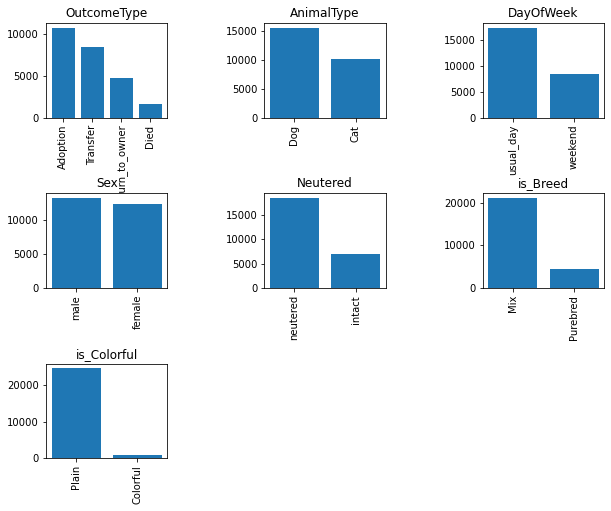

In [209]:
fig = plt.figure(figsize=(10, 8))
fig.subplots_adjust(hspace=0.8, wspace=0.8)
for i,var in enumerate(obj_col):
    tmp = train[var].value_counts().reset_index()
    ax = fig.add_subplot(3, 3, i+1)
    ax.bar(tmp['index'], tmp[var])
    ax.set_title(var)
    ax.set_xticklabels(tmp['index'], rotation=90)

In [210]:
for i in obj_col:
    print("Column: ", i, "\n")
    print(train[i].value_counts(),"\n***\n")

Column:  OutcomeType 

Adoption           10769
Transfer            8455
Return_to_owner     4773
Died                1624
Name: OutcomeType, dtype: int64 
***

Column:  AnimalType 

Dog    15516
Cat    10105
Name: AnimalType, dtype: int64 
***

Column:  DayOfWeek 

usual_day    17279
weekend       8342
Name: DayOfWeek, dtype: int64 
***

Column:  Sex 

male      13298
female    12323
Name: Sex, dtype: int64 
***

Column:  Neutered 

neutered    18598
intact       7023
Name: Neutered, dtype: int64 
***

Column:  is_Breed 

Mix         21214
Purebred     4407
Name: is_Breed, dtype: int64 
***

Column:  is_Colorful 

Plain       24713
Colorful      908
Name: is_Colorful, dtype: int64 
***



What we learned from these plots:
- animals get adopted more often than anything else;
- fewer cats end up in the shelter, but this is not critical;
- there are only two days on weekends, but almost half of the events fall on them;
- the number of individuals of opposite sexes is almost the same;
- there are many more neutered animals;
- and the mix in color and breed, as expected, is more common.

<AxesSubplot:xlabel='AnimalType', ylabel='count'>

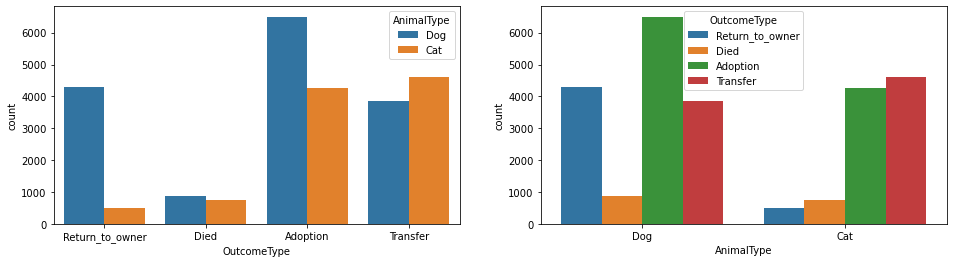

In [211]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.countplot(data=train, x='OutcomeType',hue='AnimalType', ax=ax1)
sns.countplot(data=train, x='AnimalType',hue='OutcomeType', ax=ax2)

Dogs have higer chance to return to owner than cats. And the most popular outcome type for cats is transfer, when for dogs is adoption

<AxesSubplot:xlabel='DayOfWeek', ylabel='count'>

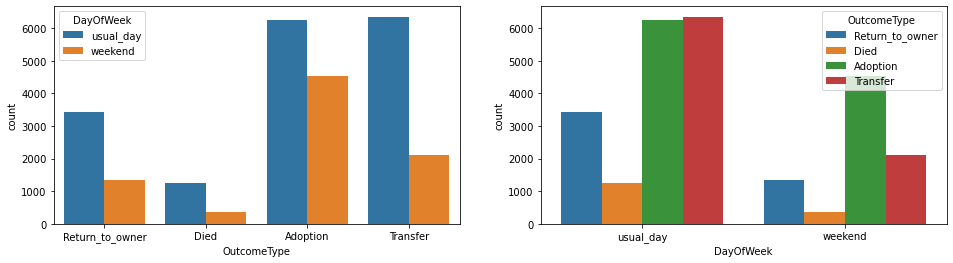

In [212]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.countplot(data=train, x='OutcomeType',hue='DayOfWeek', ax=ax1)
sns.countplot(data=train, x='DayOfWeek',hue='OutcomeType', ax=ax2)

Even though there are a lot of adoption on weekends. On weekdays, animals are still picked up more often, but transfers almost do not occur on weekends.

<AxesSubplot:xlabel='Hour', ylabel='count'>

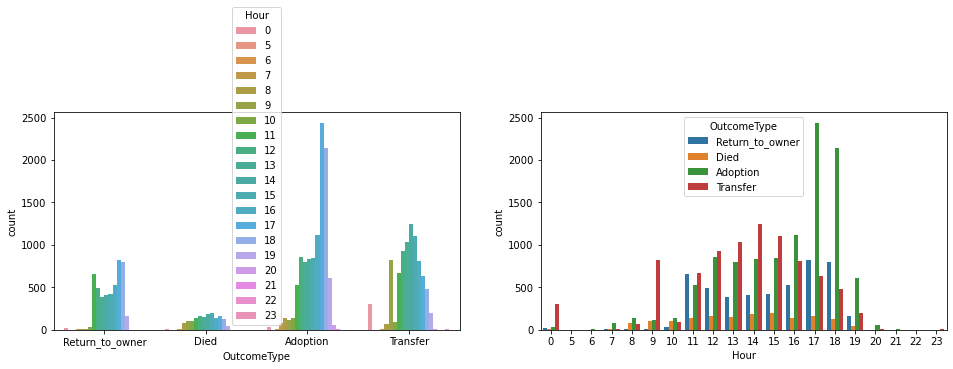

In [213]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.countplot(data=train, x='OutcomeType',hue='Hour', ax=ax1)
sns.countplot(data=train, x='Hour',hue='OutcomeType', ax=ax2)

The peak of adoption falls on 17 18 hours of the day. most likely because most of people end their work somewhere around this time. The transfer peak at midnight is also looks interesting.

<AxesSubplot:xlabel='is_Breed', ylabel='count'>

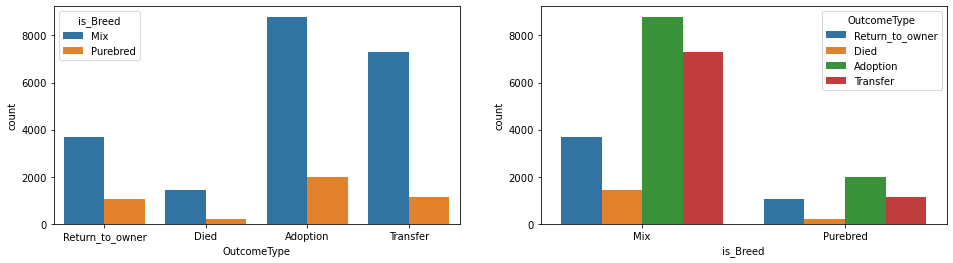

In [214]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.countplot(data=train, x='OutcomeType',hue='is_Breed', ax=ax1)
sns.countplot(data=train, x='is_Breed',hue='OutcomeType', ax=ax2)

It seems that everything and everywhere is better for the mix, but in fact, on the right graph you can see that in both cases everything is the same, it’s just that there are fewer purebred animals themselves

<AxesSubplot:xlabel='is_Colorful', ylabel='count'>

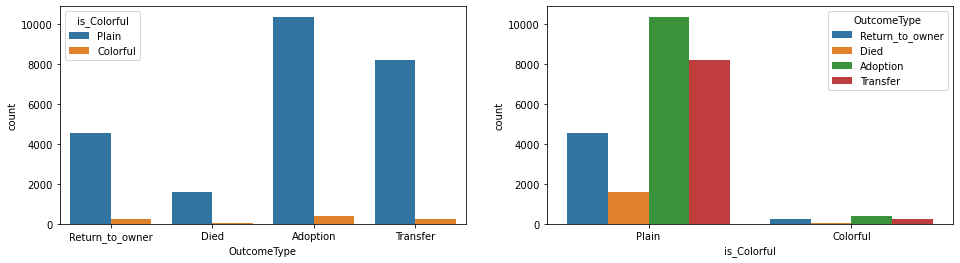

In [215]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.countplot(data=train, x='OutcomeType',hue='is_Colorful', ax=ax1)
sns.countplot(data=train, x='is_Colorful',hue='OutcomeType', ax=ax2)

Same... Looks like my assumption was wrong

<AxesSubplot:xlabel='Neutered', ylabel='count'>

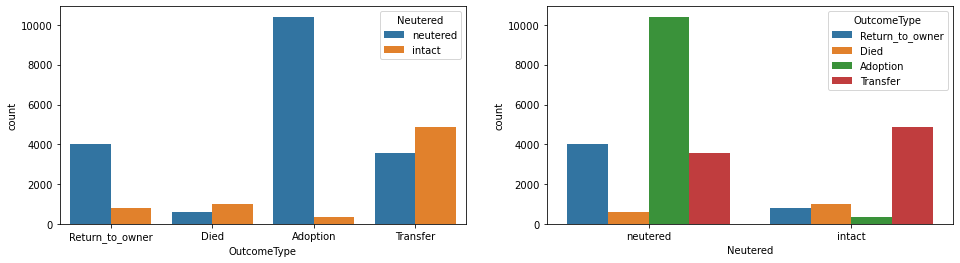

In [216]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.countplot(data=train, x='OutcomeType',hue='Neutered', ax=ax1)
sns.countplot(data=train, x='Neutered',hue='OutcomeType', ax=ax2)

It can be seen that the castrated are taken more often and not the castrated are transfer more often. It is worth looking at the connection of castration with the type of animal

<AxesSubplot:xlabel='AnimalType', ylabel='count'>

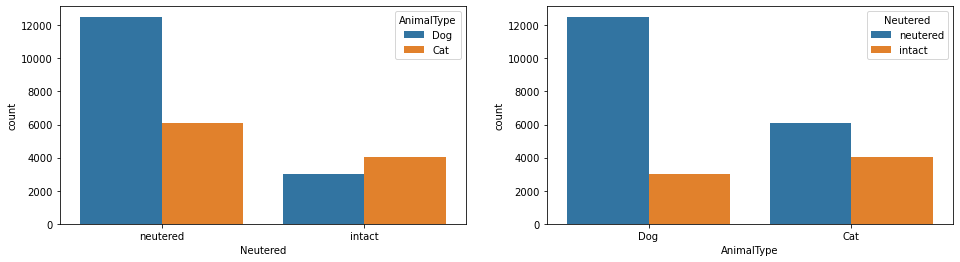

In [217]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.countplot(data=train, x='Neutered',hue='AnimalType', ax=ax1)
sns.countplot(data=train, x='AnimalType',hue='Neutered', ax=ax2)

Cats remain intact more often than dogs. But still they are castrated in a little more than half of the cases.

<AxesSubplot:xlabel='Sex', ylabel='count'>

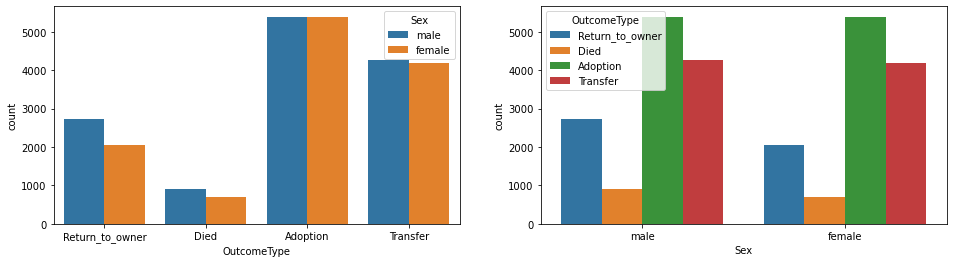

In [218]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.countplot(data=train, x='OutcomeType',hue='Sex', ax=ax1)
sns.countplot(data=train, x='Sex',hue='OutcomeType', ax=ax2)

No useful information here

Text(0.5, 1.0, 'AgeuponOutcome')

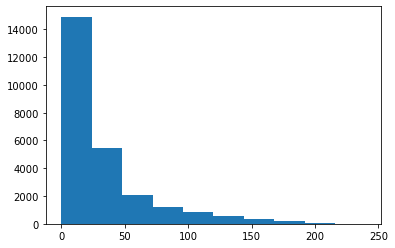

In [219]:
plt.hist(train['AgeuponOutcome'])
ax.set_title('AgeuponOutcome')

Let's divide age into 4 parts.

In [220]:
def age_category(x):
    if x <= 36: return 'young'
    if x <= 60: return 'young adult'
    if x <= 120: return 'adult'
    return 'old'
train['AgeCategory'] = train.AgeuponOutcome.apply(age_category)

<AxesSubplot:xlabel='AgeCategory', ylabel='count'>

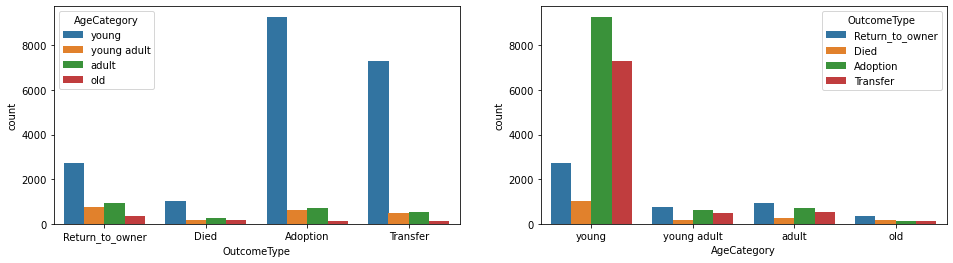

In [221]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.countplot(data=train, x='OutcomeType',hue='AgeCategory', ax=ax1)
sns.countplot(data=train, x='AgeCategory',hue='OutcomeType', ax=ax2)

The younger you are, the more likely you are to be adopted.

##  Feature Selection

In [222]:
train = train.drop(['is_Breed','is_Colorful',"AgeCategory"],axis = 1)
train.reset_index(drop= True , inplace= True )

Let's delete columns that we won't use for training.

In [223]:
train.head()

,OutcomeType,AnimalType,AgeuponOutcome,Breed,Color,Month,DayOfWeek,Hour,Sex,Neutered
0,Return_to_owner,Dog,12,Shetland Sheepdog Mix,Brown White,2,usual_day,18,male,neutered
1,Died,Cat,12,Domestic Shorthair Mix,Cream Tabby,10,weekend,12,female,neutered
2,Adoption,Dog,24,Pit Bull Mix,Blue White,1,weekend,12,male,neutered
3,Transfer,Cat,0,Domestic Shorthair Mix,Blue Cream,7,usual_day,19,male,intact
4,Transfer,Dog,24,Lhasa Apso Miniature Poodle,Tan,11,usual_day,12,male,neutered


We will split train and test set and create Y for multiclass and binary classification.

In [224]:
X = train.drop("OutcomeType", axis=1)
Y = train["OutcomeType"].copy()

In [225]:
Y_encoder = LabelEncoder()

In [226]:
Y_mul = Y

In [227]:
Y = Y.replace(to_replace=['Died', 'Divorced','Return_to_owner','Transfer'], value='Not_adopted')

In [228]:
Y.value_counts()

Not_adopted    14852
Adoption       10769
Name: OutcomeType, dtype: int64

In [229]:
Y = Y_encoder.fit_transform(Y)

In [230]:
Y_encoder.classes_

array(['Adoption', 'Not_adopted'], dtype=object)

In [231]:
Y

array([1, 1, 0, ..., 0, 1, 1])

Then it's time to convert our text columns to numerical data. I will use CountVectorizer

In [232]:
color_vectorizer = CountVectorizer()
bag_of_words = color_vectorizer.fit_transform(X['Color'])
bag_of_color = pd.DataFrame(bag_of_words.toarray(), columns = color_vectorizer.get_feature_names())
breed_vectorizer = CountVectorizer()
bag_of_words = breed_vectorizer.fit_transform(X['Breed'])
bag_of_breed = pd.DataFrame(bag_of_words.toarray(), columns = breed_vectorizer.get_feature_names())

In [233]:
bag_of_breed

,abyssinian,affenpinscher,afghan,airedale,akita,alaskan,american,anatol,angora,apso,...,weimaraner,welsh,west,wheaten,whippet,wire,wirehair,wirehaired,wolfhound,yorkshire
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25616,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25617,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25618,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25619,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


After this encode categorical and some of numerical data

In [234]:
labelencoder = LabelEncoder()
def Encode(train_set, rows_to_le, rows_to_oe, rows_to_let):
    for i in rows_to_le:
        train_set[i] = labelencoder.fit_transform(train_set[i])
    for i in rows_to_oe:
        train_set = pd.get_dummies(data=train_set,columns=[i])
    for i in rows_to_let:
        train_set[i] = labelencoder.transform(train_set[i])
    return train_set

In [235]:
oe = ['AnimalType','Sex','Neutered']
le =['DayOfWeek']
X = Encode(X,le,oe,[])

In [236]:
X.head()

,AgeuponOutcome,Breed,Color,Month,DayOfWeek,Hour,AnimalType_Cat,AnimalType_Dog,Sex_female,Sex_male,Neutered_intact,Neutered_neutered
0,12,Shetland Sheepdog Mix,Brown White,2,0,18,0,1,0,1,0,1
1,12,Domestic Shorthair Mix,Cream Tabby,10,1,12,1,0,1,0,0,1
2,24,Pit Bull Mix,Blue White,1,1,12,0,1,0,1,0,1
3,0,Domestic Shorthair Mix,Blue Cream,7,0,19,1,0,0,1,1,0
4,24,Lhasa Apso Miniature Poodle,Tan,11,0,12,0,1,0,1,0,1


And put it all together

In [237]:
result = pd.concat([X, bag_of_breed,bag_of_color], axis=1)
X = result

In [238]:
X = X.drop(['Breed','Color'], axis = 1)

In [239]:
def age_category(x):
    if x < 36: return 0
    if x < 60: return 1
    if x < 120: return 2
    return 3
train['AgeuponOutcome'] = train.AgeuponOutcome.apply(age_category)

In [240]:
X.head()

,AgeuponOutcome,Month,DayOfWeek,Hour,AnimalType_Cat,AnimalType_Dog,Sex_female,Sex_male,Neutered_intact,Neutered_neutered,...,smoke,tabby,tan,tick,tiger,torbie,tortie,tricolor,white,yellow
0,12,2,0,18,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
1,12,10,1,12,1,0,1,0,0,1,...,0,1,0,0,0,0,0,0,0,0
2,24,1,1,12,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
3,0,7,0,19,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,24,11,0,12,0,1,0,1,0,1,...,0,0,1,0,0,0,0,0,0,0


## Data Scaling

In [241]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
scale_train = sc.fit_transform(X)
#scale_test = sc.transform(X)

## Model Selection

In [242]:
X_train, X_test, Y_train, Y_test = train_test_split(scale_train, Y, test_size=0.3, random_state=0)

In [152]:
classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
]

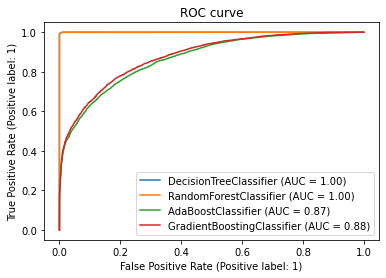

In [153]:
fig, ax = plt.subplots()

model_displays = {}
for clf in classifiers:
    clf.fit(X_train, Y_train)
    name = type(clf).__name__
    model_displays[type(clf).__name__] = plot_roc_curve(
        clf, X_train, Y_train, ax=ax, name=name)
_ = ax.set_title('ROC curve')

In [154]:
potential_model = ['DecisionTreeClassifier', 'RandomForestClassifier', 'AdaBoostClassifier', 'GradientBoostingClassifier']
for clf in classifiers:
    name = type(clf).__name__
    if name in potential_model:
        predictions =clf.predict(X_test)
        cm = confusion_matrix(Y_test, predictions, labels=clf.classes_)
        cr = classification_report(y_true=Y_test, 
                                   y_pred=predictions,
                                   target_names=Y_encoder.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
        print(f"\n{name}:\n{cr}")
        print(f"{cm}")


DecisionTreeClassifier:
              precision    recall  f1-score   support

    Adoption       0.69      0.68      0.68      3280
 Not_adopted       0.76      0.77      0.77      4407

    accuracy                           0.73      7687
   macro avg       0.73      0.72      0.73      7687
weighted avg       0.73      0.73      0.73      7687

[[2215 1065]
 [ 993 3414]]

RandomForestClassifier:
              precision    recall  f1-score   support

    Adoption       0.73      0.71      0.72      3280
 Not_adopted       0.79      0.81      0.80      4407

    accuracy                           0.77      7687
   macro avg       0.76      0.76      0.76      7687
weighted avg       0.77      0.77      0.77      7687

[[2330  950]
 [ 847 3560]]

AdaBoostClassifier:
              precision    recall  f1-score   support

    Adoption       0.76      0.70      0.73      3280
 Not_adopted       0.79      0.83      0.81      4407

    accuracy                           0.78      7687
   

In [69]:
rfc=RandomForestClassifier(random_state=42)

In [70]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

#from sklearn.ensemble import RandomForestRegressor
rf_random = RandomizedSearchCV(estimator = rfc, param_distributions = param_grid, n_iter = 100, cv = 3, random_state=42)
rf_random.fit(X_train, Y_train)

D:\games\Conda\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 60 is smaller than n_iter=100. Running 60 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [4, 5, 6, 7, 8],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': [200, 500]},
                   random_state=42)

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, Y_train)

In [71]:
rf_random.best_params_

{'n_estimators': 500,
 'max_features': 'auto',
 'max_depth': 8,
 'criterion': 'entropy'}

In [72]:
rf_random.best_score_

0.7629084420653508

In [73]:
rf_random.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators=500,
                       random_state=42)

In [243]:
clf=RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators=500,
                       random_state=42)

In [244]:
clf.fit(X_train, Y_train)
predictions =clf.predict(X_test)
cm = confusion_matrix(Y_test, predictions, labels=clf.classes_)
cr = classification_report(y_true=Y_test, 
                            y_pred=predictions,
                            target_names=Y_encoder.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
print(f"\n{cr}")
print(f"{cm}")


              precision    recall  f1-score   support

    Adoption       0.73      0.66      0.70      3280
 Not_adopted       0.77      0.82      0.79      4407

    accuracy                           0.75      7687
   macro avg       0.75      0.74      0.74      7687
weighted avg       0.75      0.75      0.75      7687

[[2176 1104]
 [ 798 3609]]


In [245]:
with open("model.bin", 'wb') as f_out:
    pickle.dump(clf, f_out) # write final_model in .bin file
    f_out.close()  # close the file

In [246]:
def data_tranformer(data):
    data = data.drop(['ID','Name'], axis=1)
    data['SexuponOutcome'].replace(to_replace=['Unknown'], value=[np.nan], inplace = True)
    data.dropna(subset=['AgeuponOutcome','SexuponOutcome'], inplace=True)
    data["DateTime"]=pd.to_datetime(data["DateTime"])
    data["Month"] = data["DateTime"].dt.month
    data["DayOfWeek"] = data["DateTime"].dt.dayofweek
    data["Hour"] = data["DateTime"].dt.hour
    data= data.drop(['DateTime'], axis=1)
    data['DayOfWeek'] = data.DayOfWeek.apply(day)
    data = to_month(data, 'AgeuponOutcome')
    data['Sex'] = data.SexuponOutcome.apply(get_sex)
    data['Neutered'] = data.SexuponOutcome.apply(get_neutered)
    data = data.drop(['SexuponOutcome'],axis = 1)
    data = pure_text(data, 'Breed')
    data = pure_text(data, 'Color')
    data.reset_index(drop= True , inplace= True )
    bag_of_words = color_vectorizer.transform(data['Color'])
    bag_of_color = pd.DataFrame(bag_of_words.toarray(), columns = color_vectorizer.get_feature_names())
    bag_of_words = breed_vectorizer.transform(data['Breed'])
    bag_of_breed = pd.DataFrame(bag_of_words.toarray(), columns = breed_vectorizer.get_feature_names())
    data = Encode(data,[],oe,le)
    data = pd.concat([data, bag_of_breed,bag_of_color], axis=1)
    data = data.drop(['Breed','Color'], axis = 1)
    data['AgeuponOutcome'] = data.AgeuponOutcome.apply(age_category)
    scale_test = sc.transform(data)
    return scale_test

In [269]:
keys = labelencoder.classes_
values = labelencoder.transform(labelencoder.classes_)
dictionary = dict(zip(keys, values))
print(dictionary)

{'usual_day': 0, 'weekend': 1}


In [287]:
dictionary.keys()

dict_keys(['usual_day', 'weekend'])

In [295]:
def preprocess_le_cols(df):
    df["DayOfWeek"] = df["DayOfWeek"].map(dictionary)    
    return df

In [296]:
bag_of_words.get_params()

AttributeError: get_params not found

dict_keys([])

In [247]:
with open('model.bin', 'rb') as f_in:
    model = pickle.load(f_in)

In [248]:
test = data_tranformer(test)

In [251]:
y_pred = model.predict(test)

In [252]:
y_pred

array([1, 1, 1, ..., 1, 0, 1])

## Multiclass classification

I also was trying multiclass classification, but can't resive good enough scores.

In [76]:
classifiers1 = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    ExtraTreeClassifier(),
    GaussianNB(),
    BernoulliNB(),
    LogisticRegression(multi_class='multinomial'),
    LogisticRegressionCV(multi_class='multinomial'),
    LinearSVC(multi_class='crammer_singer')
]

In [82]:
Y_mul = Y_encoder.fit_transform(Y_mul)

In [83]:
X_train, X_test, Y_train, Y_test = train_test_split(scale_train, Y_mul, test_size=0.3, random_state=0)

In [84]:
potential_model = ['KNeighborsClassifier','DecisionTreeClassifier','ExtraTreeClassifier','GaussianNB',
                   'BernoulliNB','LogisticRegression','LinearSVC']
for clf in classifiers1:
    name = type(clf).__name__
    if name in potential_model:
        clf.fit(X_train, Y_train)
        predictions =clf.predict(X_test)
        cm = confusion_matrix(Y_test, predictions, labels=clf.classes_)
        cr = classification_report(y_true=Y_test, 
                                   y_pred=predictions,
                                   target_names=Y_encoder.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
        print(f"\n{name}:\n{cr}")
        print(f"{cm}")


KNeighborsClassifier:
                 precision    recall  f1-score   support

       Adoption       0.59      0.78      0.67      3280
           Died       0.26      0.09      0.13       504
Return_to_owner       0.37      0.30      0.33      1393
       Transfer       0.66      0.54      0.59      2510

       accuracy                           0.57      7687
      macro avg       0.47      0.43      0.43      7687
   weighted avg       0.55      0.57      0.55      7687

[[2557   18  385  320]
 [ 173   46   87  198]
 [ 752   32  422  187]
 [ 825   84  258 1343]]

DecisionTreeClassifier:
                 precision    recall  f1-score   support

       Adoption       0.69      0.67      0.68      3280
           Died       0.24      0.23      0.23       504
Return_to_owner       0.38      0.40      0.39      1393
       Transfer       0.63      0.63      0.63      2510

       accuracy                           0.58      7687
      macro avg       0.48      0.48      0.48      7687

D:\games\Conda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



LogisticRegression:
                 precision    recall  f1-score   support

       Adoption       0.65      0.85      0.73      3280
           Died       0.38      0.08      0.14       504
Return_to_owner       0.47      0.33      0.39      1393
       Transfer       0.68      0.62      0.65      2510

       accuracy                           0.63      7687
      macro avg       0.54      0.47      0.48      7687
   weighted avg       0.61      0.63      0.60      7687

[[2777    6  268  229]
 [  87   42   84  291]
 [ 686   32  465  210]
 [ 752   30  181 1547]]

LinearSVC:
                 precision    recall  f1-score   support

       Adoption       0.61      0.91      0.73      3280
           Died       0.02      0.00      0.00       504
Return_to_owner       0.43      0.20      0.28      1393
       Transfer       0.68      0.58      0.63      2510

       accuracy                           0.61      7687
      macro avg       0.44      0.42      0.41      7687
   weighted av

D:\games\Conda\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [85]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 30, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, Y_train)

RandomForestClassifier(criterion='entropy', n_estimators=30, random_state=0)

In [86]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)
y_prob = classifier.predict_proba(X_test)
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, y_pred)  
print(cm)

[[2600   21  358  301]
 [  91   54  107  252]
 [ 609   28  516  240]
 [ 571   55  235 1649]]


In [87]:
# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = Y_train, cv = 10)
print(accuracies.mean())
print(accuracies.std())

0.6247911331133523
0.008147807616580243


Even with Random Forest Classifier it is not good enough. Maybe problem with data, and maybe I don't have enough skills.